In [ ]:
from google.colab import files
uploaded = files.upload()

Dataset shape: (5000, 29)
First few rows:
   1.000000000000000000e+00  8.692932128906250000e-01  \
0                       0.0                  1.043884   
1                       1.0                  0.889241   
2                       1.0                  1.468282   
3                       0.0                  0.642179   
4                       0.0                  2.032682   

   -6.350818276405334473e-01  2.256902605295181274e-01  \
0                   0.040853                 -0.851956   
1                   0.741136                 -0.612256   
2                  -0.407173                  0.602441   
3                  -0.788969                 -0.425820   
4                  -1.414257                 -0.920204   

   3.274700641632080078e-01  -6.899932026863098145e-01  \
0                  0.487162                   1.344852   
1                  0.536777                  -0.637018   
2                  1.607870                   0.053964   
3                  0.505537       

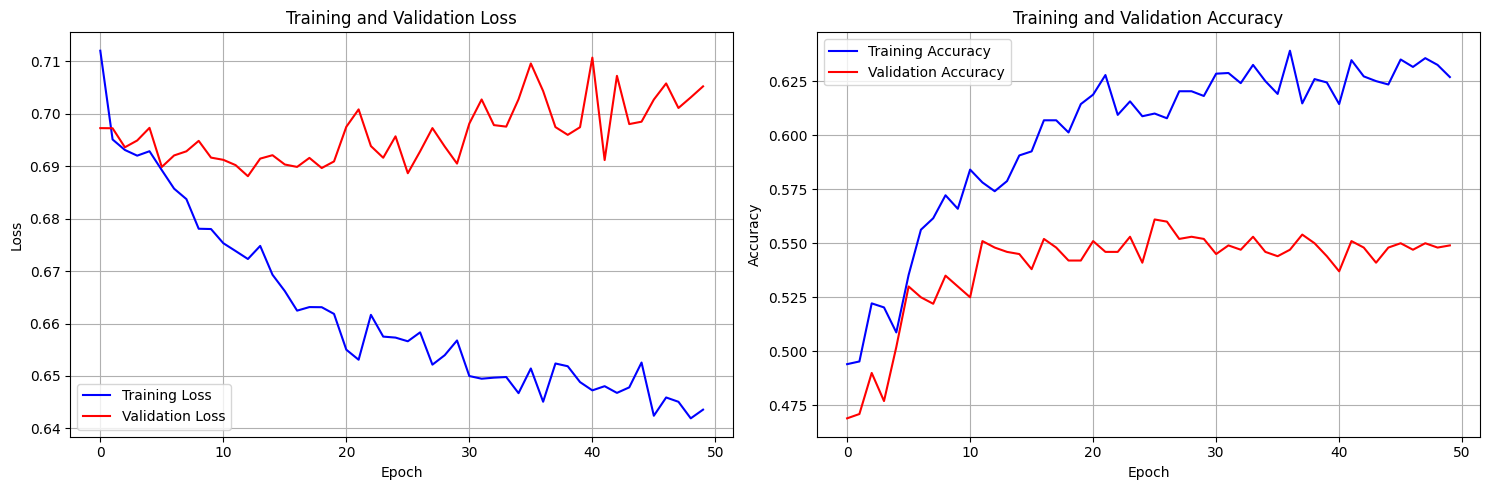

Confusion Matrix:
[[202 198]
 [161 239]]
Test Accuracy: 0.5513


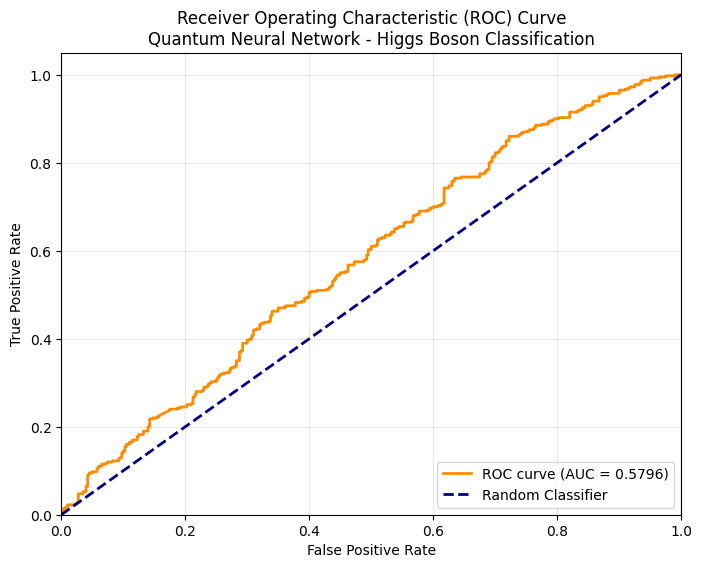

ROC AUC Score: 0.5796


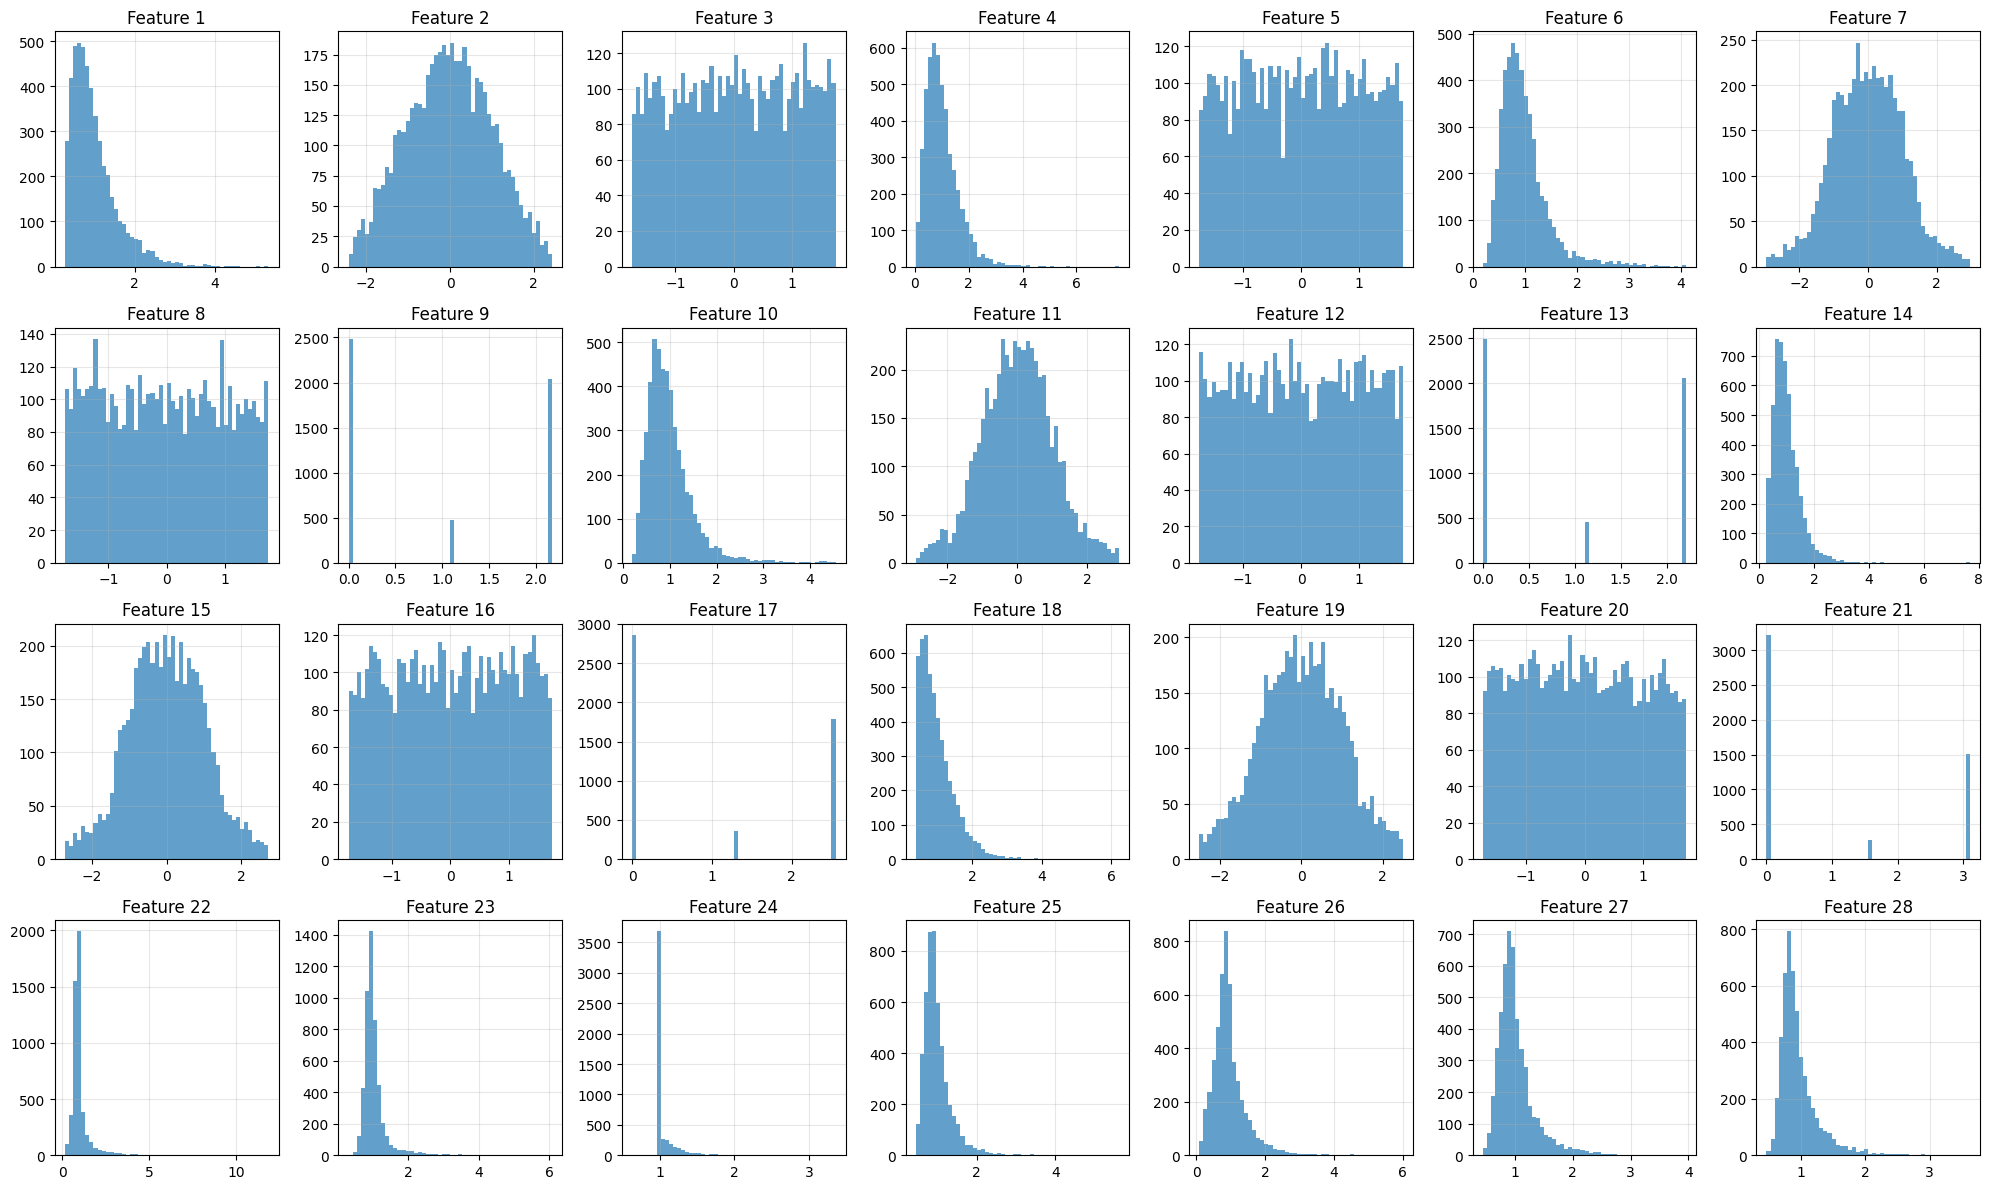

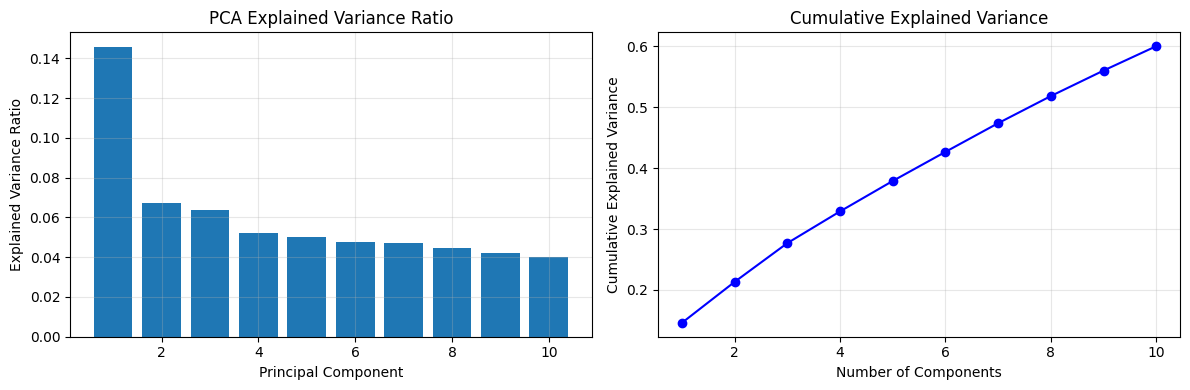

TRAINING COMPLETE!
Final Test Accuracy: 0.5513
Final ROC AUC: 0.5796
Total Model Parameters: 534
Number of Qubits Used: 10
Number of Quantum Layers: 6


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
import pennylane as qml
from pennylane import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import pandas as pd
import copy
import time

# For reproducibility
np.random.seed(1337)
torch.manual_seed(1337)

# ========================================
# 2. DATA LOADING AND PREPROCESSING
# ========================================
# Load the dataset
data_path = 'challenge_higgs_data.csv'
data = pd.read_csv(data_path)

print(f"Dataset shape: {data.shape}")
print(f"First few rows:")
print(data.head())

# Separate features and labels
X = data.iloc[:, 1:]  # All columns except first (features)
y = data.iloc[:, 0]   # First column (labels: 1 for signal, 0 for background)

print(f"Features shape: {X.shape}")
print(f"Labels distribution:")
print(y.value_counts())

# ========================================
# 3. DATA PREPROCESSING
# ========================================
def preprocess_data(X, y, test_size_val=0.2, test_size_test=0.2, n_components=10): #
    """
    Comprehensive data preprocessing pipeline
    """
    # Split the data
    X_train_full, X_val, y_train_full, y_val = train_test_split(
        X, y, test_size=test_size_val, random_state=42, stratify=y
    )

    X_train, X_test, y_train, y_test = train_test_split(
        X_train_full, y_train_full, test_size=test_size_test, random_state=42, stratify=y_train_full
    )

    print(f"Training set size: {X_train.shape[0]}")
    print(f"Validation set size: {X_val.shape[0]}")
    print(f"Test set size: {X_test.shape[0]}")

    # Standardization
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_test)

    # Dimensionality reduction using PCA (important for quantum circuits)
    pca = PCA(n_components=n_components)
    X_train_pca = pca.fit_transform(X_train_scaled)
    X_val_pca = pca.transform(X_val_scaled)
    X_test_pca = pca.transform(X_test_scaled)

    print(f"PCA explained variance ratio: {pca.explained_variance_ratio_}")
    print(f"Total explained variance: {pca.explained_variance_ratio_.sum():.4f}")

    # Normalize to [0, 2π] for quantum encoding
    normalizer = MinMaxScaler(feature_range=(0, 2*np.pi))
    X_train_final = normalizer.fit_transform(X_train_pca)
    X_val_final = normalizer.transform(X_val_pca)
    X_test_final = normalizer.transform(X_test_pca)

    return (X_train_final, X_val_final, X_test_final,
            y_train.values, y_val.values, y_test.values,
            scaler, pca, normalizer)

# Apply preprocessing
(X_train, X_val, X_test, y_train, y_val, y_test,
 scaler, pca, normalizer) = preprocess_data(X, y, n_components=10)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Create datasets and dataloaders
batch_size = 32
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

dataloaders = {
    "train": DataLoader(train_dataset, batch_size=batch_size, shuffle=True),
    "validation": DataLoader(val_dataset, batch_size=batch_size, shuffle=False),
    "test": DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
}

dataset_sizes = {
    "train": len(train_dataset),
    "validation": len(val_dataset),
    "test": len(test_dataset)
}
print(f"Dataset sizes: {dataset_sizes}")

# ========================================
# 4. QUANTUM NEURAL NETWORK DEFINITION
# ========================================
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Quantum device setup
n_qubits = X_train.shape[1] # Number of features after PCA
if n_qubits > 20:
    print(f"Warning: n_qubits ({n_qubits}) exceeds the 20 qubit limit. Adjusting to 20.")
    n_qubits = 20
n_layers = 6

dev = qml.device("default.qubit", wires=n_qubits)

@qml.qnode(dev, interface="torch")
def quantum_circuit(inputs, weights):
    """
    Quantum variational circuit with data encoding and variational layers
    """
    # Data encoding using angle embedding
    qml.AngleEmbedding(inputs, wires=range(n_qubits))

    # Variational layers
    for layer in range(n_layers):
        # Parameterized rotations
        for qubit in range(n_qubits):
            qml.RY(weights[layer, qubit, 0], wires=qubit)
            qml.RZ(weights[layer, qubit, 1], wires=qubit)

        # Entangling gates
        for qubit in range(n_qubits):
            qml.CNOT(wires=[qubit, (qubit + 1) % n_qubits]) # Circular entanglement

    # Measurements
    # M
    return [qml.expval(qml.PauliZ(wires=i)) for i in range(n_qubits)]

class HybridQuantumNet(nn.Module):
    """
    Hybrid Quantum-Classical Neural Network for Higgs Boson Classification
    """

    def __init__(self, n_qubits, n_layers):
        super().__init__()
        self.n_qubits = n_qubits
        self.n_layers = n_layers

        # Quantum layer weights
        weight_shapes = {"weights": (n_layers, n_qubits, 2)}
        self.quantum_layer = qml.qnn.TorchLayer(quantum_circuit, weight_shapes)

        # Classical post-processing layers
        self.fc1 = nn.Linear(n_qubits, 16) # Input size from quantum layer output
        self.bn1 = nn.BatchNorm1d(16)
        self.fc2 = nn.Linear(16, 8)
        self.bn2 = nn.BatchNorm1d(8)
        self.fc3 = nn.Linear(8, 4)
        self.bn3 = nn.BatchNorm1d(4)
        self.fc4 = nn.Linear(4, 2)
        self.dropout = nn.Dropout(0.1) # Reduced dropout

        self.relu = nn.ReLU()

    def forward(self, x):
        # Quantum processing
        x = self.quantum_layer(x)

        # Classical post-processing
        x = self.bn1(self.relu(self.fc1(x)))
        x = self.dropout(x)
        x = self.bn2(self.relu(self.fc2(x)))
        x = self.dropout(x)
        x = self.bn3(self.relu(self.fc3(x)))
        x = self.dropout(x)
        x = self.fc4(x)

        return x

# Initialize the model
model = HybridQuantumNet(n_qubits, n_layers).to(device)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
print(f"Total model parameters: {total_params}")

# ========================================
# 5. TRAINING SETUP
# ========================================

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.005, weight_decay=1e-5) # Slightly lower LR, reduced weight_decay
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.7) # Adjusted scheduler

def train_model(model, criterion, optimizer, scheduler, num_epochs):
    """
    Training function with tracking of metrics
    """
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    best_loss = float('inf')

    # For plotting
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []

    print("Training started:")
    print("-" * 50)

    for epoch in range(num_epochs):
        epoch_metrics = {}

        # Each epoch has a training and validation phase
        for phase in ["train", "validation"]:
            if phase == "train":
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0
            n_samples = 0

            # Iterate over data
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                # Forward pass
                with torch.set_grad_enabled(phase == "train"):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == "train":
                        loss.backward()
                        optimizer.step()

                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                n_samples += inputs.size(0)

            epoch_loss = running_loss / n_samples
            epoch_acc = running_corrects.double() / n_samples

            epoch_metrics[f"{phase}_loss"] = epoch_loss
            epoch_metrics[f"{phase}_acc"] = epoch_acc.item()

            # Store metrics for plotting
            if phase == "train":
                train_losses.append(epoch_loss)
                train_accs.append(epoch_acc.item())
            else:
                val_losses.append(epoch_loss)
                val_accs.append(epoch_acc.item())

        # Step scheduler
        if scheduler:
            scheduler.step()

        # Print epoch results
        print(f'Epoch {epoch+1}/{num_epochs}:')
        print(f'  Train Loss: {epoch_metrics["train_loss"]:.4f} Acc: {epoch_metrics["train_acc"]:.4f}')
        print(f'  Val Loss: {epoch_metrics["validation_loss"]:.4f} Acc: {epoch_metrics["validation_acc"]:.4f}')

        # Save best model
        if epoch_metrics["validation_acc"] > best_acc:
            best_acc = epoch_metrics["validation_acc"]
            best_model_wts = copy.deepcopy(model.state_dict())

        if epoch_metrics["validation_loss"] < best_loss:
            best_loss = epoch_metrics["validation_loss"]

        print("-" * 30)

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best Val Acc: {best_acc:.4f}')

    # Load best model weights
    model.load_state_dict(best_model_wts)

    return model, train_losses, val_losses, train_accs, val_accs

# ========================================
# 6. MODEL TRAINING
# ========================================
print("Starting training...")
trained_model, train_losses, val_losses, train_accs, val_accs = train_model(
    model, criterion, optimizer, scheduler, num_epochs=50 # Increased epochs
)

# Save the trained model
torch.save(trained_model.state_dict(), 'quantum_higgs_model.pth')
print("Model saved as 'quantum_higgs_model.pth'")

# ========================================
# 7. PLOTTING TRAINING METRICS
# ========================================
# Plot training and validation metrics
fig, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(15, 5))

# Loss plot
ax1.plot(train_losses, label='Training Loss', color='blue')
ax1.plot(val_losses, label='Validation Loss', color='red')
ax1.set_title('Training and Validation Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid(True)

# Accuracy plot
ax2.plot(train_accs, label='Training Accuracy', color='blue')
ax2.plot(val_accs, label='Validation Accuracy', color='red')
ax2.set_title('Training and Validation Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

# ========================================
# 8. MODEL EVALUATION
# ========================================
# Evaluate on test set
trained_model.eval()
test_outputs = []
test_labels = []

with torch.no_grad():
    for inputs, labels in dataloaders["test"]:
        inputs = inputs.to(device)
        outputs = trained_model(inputs)
        probabilities = torch.softmax(outputs, dim=1)
        test_outputs.append(probabilities.cpu())
        test_labels.append(labels)

# Concatenate all predictions
y_pred_proba = torch.cat(test_outputs, dim=0).numpy()
y_test_eval = torch.cat(test_labels, dim=0).numpy()
y_pred = y_pred_proba[:, 1]  # Probability of class 1 (signal)

# Print confusion matrix
y_pred_class = (y_pred > 0.5).astype(int)
cm = confusion_matrix(y_test_eval, y_pred_class)
print("Confusion Matrix:")
print(cm)

# Calculate accuracy
accuracy = accuracy_score(y_test_eval, y_pred_class)
print(f"Test Accuracy: {accuracy:.4f}")

# ========================================
# 9. ROC CURVE PLOTTING
# ========================================
# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test_eval, y_pred)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve\nQuantum Neural Network - Higgs Boson Classification')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.show()

print(f"ROC AUC Score: {roc_auc:.4f}")

# ========================================
# 10. FEATURE VISUALIZATION
# ========================================
# Plot feature distributions for original data
fig, axes = plt.subplots(4, 7, figsize=(20, 12))
axes = axes.ravel()
for i in range(min(28, len(X.columns))):
    X.iloc[:, i].hist(bins=50, ax=axes[i], alpha=0.7)
    axes[i].set_title(f'Feature {i+1}')
    axes[i].grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Plot PCA components
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.bar(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_)
plt.title('PCA Explained Variance Ratio')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1),
         np.cumsum(pca.explained_variance_ratio_), 'bo-')
plt.title('Cumulative Explained Variance')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("=" * 60)
print("TRAINING COMPLETE!")
print("=" * 60)
print(f"Final Test Accuracy: {accuracy:.4f}")
print(f"Final ROC AUC: {roc_auc:.4f}")
print(f"Total Model Parameters: {total_params}")
print(f"Number of Qubits Used: {n_qubits}")
print(f"Number of Quantum Layers: {n_layers}")
print("=" * 60)

Dataset shape: (5000, 29)
Features shape: (5000, 28)
Labels distribution:
1.000000000000000000e+00
0.0    2500
1.0    2500
Name: count, dtype: int64
Training set size: 3200
Validation set size: 1000
Test set size: 800
PCA explained variance ratio: [0.14580817 0.0673275  0.06368843 0.05215604 0.05001233 0.04781798
 0.04714538 0.04459244 0.04189068 0.04007086]
Total explained variance: 0.6005
Dataset sizes: {'train': 3200, 'validation': 1000, 'test': 800}
Using device: cpu
Total model parameters: 242
Starting training...
Training started:
--------------------------------------------------
Epoch 1/25:
  Train Loss: 0.6973 Acc: 0.4941
  Val Loss: 0.6956 Acc: 0.5190
------------------------------
Epoch 2/25:
  Train Loss: 0.6914 Acc: 0.5316
  Val Loss: 0.6880 Acc: 0.5570
------------------------------
Epoch 3/25:
  Train Loss: 0.6882 Acc: 0.5409
  Val Loss: 0.6847 Acc: 0.5520
------------------------------
Epoch 4/25:
  Train Loss: 0.6837 Acc: 0.5616
  Val Loss: 0.6867 Acc: 0.5430
---------

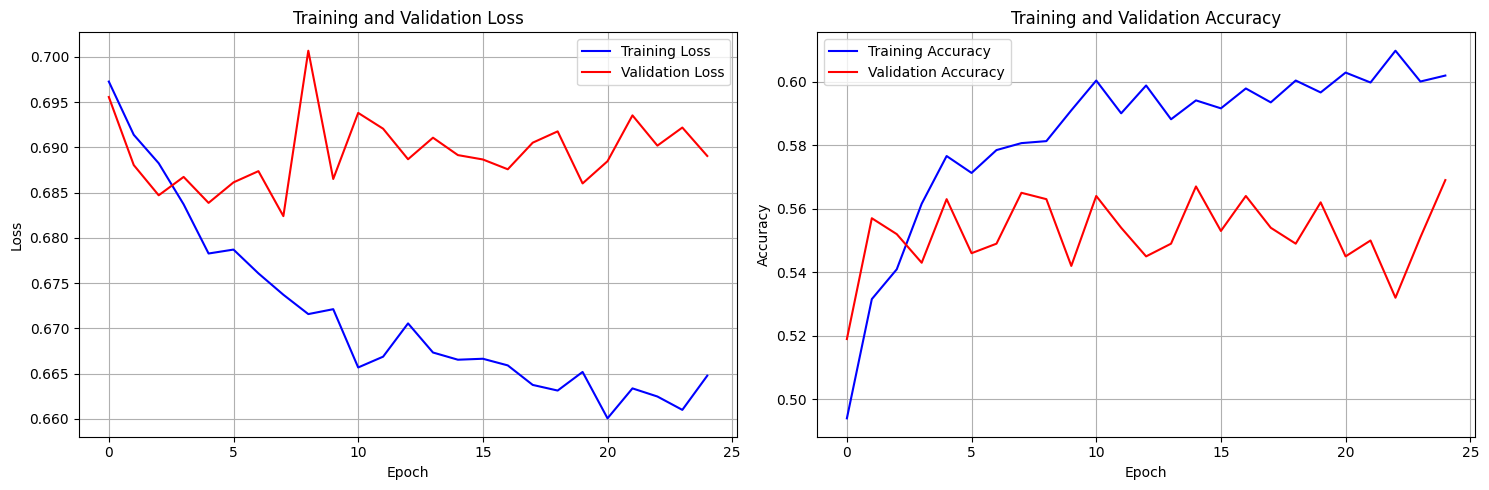

Confusion Matrix:
[[229 171]
 [169 231]]
Test Accuracy: 0.5750


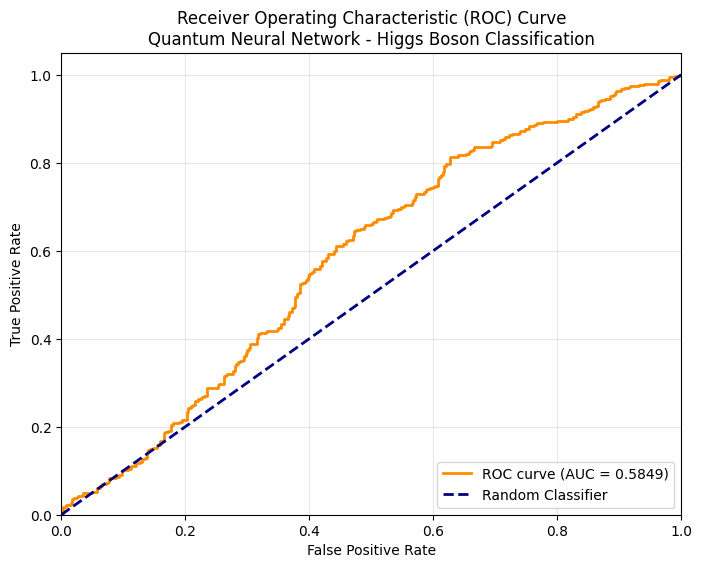

ROC AUC Score: 0.5849
TRAINING COMPLETE!
Final Test Accuracy: 0.5750
Final ROC AUC: 0.5849
Total Model Parameters: 242
Number of Qubits Used: 10
Number of Quantum Layers: 4


In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import pennylane as qml
from pennylane import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import pandas as pd
import copy
import time

# For reproducibility
np.random.seed(1337)
torch.manual_seed(1337)

# ========================================
# 2. DATA LOADING AND PREPROCESSING
# ========================================
data_path = 'challenge_higgs_data.csv'
data = pd.read_csv(data_path)
print(f"Dataset shape: {data.shape}")
X = data.iloc[:, 1:]
y = data.iloc[:, 0]
print(f"Features shape: {X.shape}")
print(f"Labels distribution:")
print(y.value_counts())

# ========================================
# 3. DATA PREPROCESSING
# ========================================
def preprocess_data(X, y, test_size_val=0.2, test_size_test=0.2, n_components=10):
    """
    Comprehensive data preprocessing pipeline
    """
    X_train_full, X_val, y_train_full, y_val = train_test_split(
        X, y, test_size=test_size_val, random_state=42, stratify=y
    )
    X_train, X_test, y_train, y_test = train_test_split(
        X_train_full, y_train_full, test_size=test_size_test, random_state=42, stratify=y_train_full
    )
    print(f"Training set size: {X_train.shape[0]}")
    print(f"Validation set size: {X_val.shape[0]}")
    print(f"Test set size: {X_test.shape[0]}")
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_test)
    pca = PCA(n_components=n_components)
    X_train_pca = pca.fit_transform(X_train_scaled)
    X_val_pca = pca.transform(X_val_scaled)
    X_test_pca = pca.transform(X_test_scaled)
    print(f"PCA explained variance ratio: {pca.explained_variance_ratio_}")
    print(f"Total explained variance: {pca.explained_variance_ratio_.sum():.4f}")
    normalizer = MinMaxScaler(feature_range=(0, 2 * np.pi))
    X_train_final = normalizer.fit_transform(X_train_pca)
    X_val_final = normalizer.transform(X_val_pca)
    X_test_final = normalizer.transform(X_test_pca)
    return (X_train_final, X_val_final, X_test_final,
            y_train.values, y_val.values, y_test.values,
            scaler, pca, normalizer)

(X_train, X_val, X_test, y_train, y_val, y_test,
 scaler, pca, normalizer) = preprocess_data(X, y, n_components=10)

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

batch_size = 32
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
dataloaders = {
    "train": DataLoader(train_dataset, batch_size=batch_size, shuffle=True),
    "validation": DataLoader(val_dataset, batch_size=batch_size, shuffle=False),
    "test": DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
}
dataset_sizes = {
    "train": len(train_dataset),
    "validation": len(val_dataset),
    "test": len(test_dataset)
}
print(f"Dataset sizes: {dataset_sizes}")

# ========================================
# 4. QUANTUM NEURAL NETWORK DEFINITION
# ========================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

n_qubits = X_train.shape[1]
if n_qubits > 20:
    print(f"Warning: n_qubits ({n_qubits}) exceeds the 20 qubit limit. Adjusting to 20.")
    n_qubits = 20

# We use fewer, more expressive quantum layers.
n_layers = 4
dev = qml.device("default.qubit", wires=n_qubits)

@qml.qnode(dev, interface="torch")
def quantum_circuit(inputs, weights):
    """
    Quantum variational circuit with a more expressive entangling layer.
    """
    # Data encoding using angle embedding
    qml.AngleEmbedding(inputs, wires=range(n_qubits))

    # We use a built-in template for a more powerful entangling circuit.
    # This can achieve better entanglement with fewer layers and parameters.
    qml.StronglyEntanglingLayers(weights=weights, wires=range(n_qubits))

    # Measurements
    return [qml.expval(qml.PauliZ(wires=i)) for i in range(n_qubits)]

class HybridQuantumNet(nn.Module):
    """
    Hybrid Quantum-Classical Neural Network with a simplified classical part.
    """
    def __init__(self, n_qubits, n_layers):
        super().__init__()
        self.n_qubits = n_qubits
        self.n_layers = n_layers

        # The weight shape for StronglyEntanglingLayers is different
        weight_shapes = {"weights": qml.StronglyEntanglingLayers.shape(n_layers=n_layers, n_wires=n_qubits)}
        self.quantum_layer = qml.qnn.TorchLayer(quantum_circuit, weight_shapes)

        # Simplified classical post-processing layers
        self.fc1 = nn.Linear(n_qubits, 8)
        self.bn1 = nn.BatchNorm1d(8)
        self.fc2 = nn.Linear(8, 2)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.1)

    def forward(self, x):
        x = self.quantum_layer(x)
        x = self.bn1(self.relu(self.fc1(x)))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

model = HybridQuantumNet(n_qubits, n_layers).to(device)

total_params = sum(p.numel() for p in model.parameters())
print(f"Total model parameters: {total_params}")

# ========================================
# 5. TRAINING SETUP
# ========================================
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01) # Increased learning rate
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.8)

def train_model(model, criterion, optimizer, scheduler, num_epochs):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []
    print("Training started:")
    print("-" * 50)
    for epoch in range(num_epochs):
        epoch_metrics = {}
        for phase in ["train", "validation"]:
            if phase == "train":
                model.train()
            else:
                model.eval()
            running_loss = 0.0
            running_corrects = 0
            n_samples = 0
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()
                with torch.set_grad_enabled(phase == "train"):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    if phase == "train":
                        loss.backward()
                        optimizer.step()
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                n_samples += inputs.size(0)
            epoch_loss = running_loss / n_samples
            epoch_acc = running_corrects.double() / n_samples
            epoch_metrics[f"{phase}_loss"] = epoch_loss
            epoch_metrics[f"{phase}_acc"] = epoch_acc.item()
            if phase == "train":
                train_losses.append(epoch_loss)
                train_accs.append(epoch_acc.item())
            else:
                val_losses.append(epoch_loss)
                val_accs.append(epoch_acc.item())
        if scheduler:
            scheduler.step()
        print(f'Epoch {epoch+1}/{num_epochs}:')
        print(f'  Train Loss: {epoch_metrics["train_loss"]:.4f} Acc: {epoch_metrics["train_acc"]:.4f}')
        print(f'  Val Loss: {epoch_metrics["validation_loss"]:.4f} Acc: {epoch_metrics["validation_acc"]:.4f}')
        if epoch_metrics["validation_acc"] > best_acc:
            best_acc = epoch_metrics["validation_acc"]
            best_model_wts = copy.deepcopy(model.state_dict())
        print("-" * 30)
    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best Val Acc: {best_acc:.4f}')
    model.load_state_dict(best_model_wts)
    return model, train_losses, val_losses, train_accs, val_accs

# ========================================
# 6. MODEL TRAINING
# ========================================
print("Starting training...")
trained_model, train_losses, val_losses, train_accs, val_accs = train_model(
    model, criterion, optimizer, scheduler, num_epochs=25 # Reduced epochs
)

torch.save(trained_model.state_dict(), 'quantum_higgs_model.pth')
print("Model saved as 'quantum_higgs_model.pth'")

# ========================================
# 7. PLOTTING TRAINING METRICS
# ========================================
fig, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(15, 5))
ax1.plot(train_losses, label='Training Loss', color='blue')
ax1.plot(val_losses, label='Validation Loss', color='red')
ax1.set_title('Training and Validation Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid(True)
ax2.plot(train_accs, label='Training Accuracy', color='blue')
ax2.plot(val_accs, label='Validation Accuracy', color='red')
ax2.set_title('Training and Validation Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend()
ax2.grid(True)
plt.tight_layout()
plt.show()

# ========================================
# 8. MODEL EVALUATION
# ========================================
trained_model.eval()
test_outputs = []
test_labels = []
with torch.no_grad():
    for inputs, labels in dataloaders["test"]:
        inputs = inputs.to(device)
        outputs = trained_model(inputs)
        probabilities = torch.softmax(outputs, dim=1)
        test_outputs.append(probabilities.cpu())
        test_labels.append(labels)
y_pred_proba = torch.cat(test_outputs, dim=0).numpy()
y_test_eval = torch.cat(test_labels, dim=0).numpy()
y_pred = y_pred_proba[:, 1]

y_pred_class = (y_pred > 0.5).astype(int)
cm = confusion_matrix(y_test_eval, y_pred_class)
print("Confusion Matrix:")
print(cm)

accuracy = accuracy_score(y_test_eval, y_pred_class)
print(f"Test Accuracy: {accuracy:.4f}")

# ========================================
# 9. ROC CURVE PLOTTING
# ========================================
fpr, tpr, thresholds = roc_curve(y_test_eval, y_pred)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve\nQuantum Neural Network - Higgs Boson Classification')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.show()
print(f"ROC AUC Score: {roc_auc:.4f}")

# ========================================
# 10. FINAL SUMMARY
# ========================================
print("=" * 60)
print("TRAINING COMPLETE!")
print("=" * 60)
print(f"Final Test Accuracy: {accuracy:.4f}")
print(f"Final ROC AUC: {roc_auc:.4f}")
print(f"Total Model Parameters: {total_params}")
print(f"Number of Qubits Used: {n_qubits}")
print(f"Number of Quantum Layers: {n_layers}")
print("=" * 60)